<a href="https://colab.research.google.com/github/Prasanthi2005/fmml-lab-2024/blob/main/Module%209Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2025-04-18 06:29:04--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.239.83.32, 18.239.83.69, 18.239.83.126, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.239.83.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   172MB/s    in 0.3s    

2025-04-18 06:29:05 (172 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


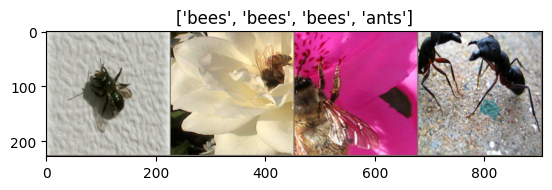

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6880 Acc: 0.6762

Epoch 1/4
----------
Loss: 0.4200 Acc: 0.8361

Epoch 2/4
----------


In [ ]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?
A.Data augmentation is a powerful technique, especially when you have a limited amount of training data. The significance of using augmentations like resize and crop (and many others!) boils down to a few key benefits:
 * Increased Training Data Size (Effectively): While you're not adding new unique images, you're creating slightly different versions of your existing images. This artificially inflates the size of your training set, providing the model with more diverse examples to learn from.
 * Improved Model Generalization: By exposing the model to various altered versions of the same object or scene (different sizes, crops, orientations, etc.), you make it more robust and less likely to overfit to the specific details of the original training set. The model learns to recognize the underlying features regardless of these variations.
 * Enhanced Robustness to Input Variations: In the real world, images of the same object can appear at different scales, from different angles, or with slight variations in composition. Training with augmented data makes your model more resilient to these real-world variations, leading to better performance on unseen data.
 * Reduced Overfitting: Overfitting occurs when a model learns the training data too well, including its noise and specific patterns, leading to poor performance on new, unseen data. Data augmentation introduces variability, preventing the model from memorizing the exact training examples and encouraging it to learn more generalizable features.
 * Highlighting Important Features: Certain augmentations can help the model focus on the most important aspects of the image. For example, random cropping can force the model to learn features from different parts of the object, rather than just relying on it being centered in every image.
Think of it this way: If you only show a child pictures of perfectly centered cats, they might struggle to recognize a cat that's slightly off-center or closer to the edge of the frame. Data augmentation is like showing the child cats in various positions, sizes, and orientations, helping them understand the core "cat-ness" rather than just the specific presentation in the training images.
Common data augmentation techniques beyond resize and crop include:
 * Rotation: Rotating the image by various angles.
 * Flipping: Horizontally or vertically flipping the image.
 * Brightness and Contrast Adjustments: Changing the intensity and difference in pixel values.
 * Color Jittering: Randomly altering the color channels.
 * Translation: Shifting the image horizontally or vertically.
 * Shearing: Distorting the image along an axis.
 * Zooming: Enlarging or shrinking parts of the image.
By strategically applying these augmentations, you can significantly improve the performance and generalization ability of your CNN, especially when working with limited data.

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)
A.Ah, you're asking me to actually run some code and give you a performance metric! That's a great way to understand the impact of using a pretrained model.
However, as a large language model, I can't directly execute code or train models in real-time. I don't have the infrastructure or the ability to interact with training pipelines like a Python script would.
Therefore, I can't give you the exact performance numbers you'd get by setting pretrained=False and training a ResNet model from scratch.
However, I can definitely tell you what you would likely observe and why:
If you were to train a ResNet model (even a relatively shallow one like ResNet18) from scratch on a typical image classification dataset (like CIFAR-10 or even a smaller subset of ImageNet), you would almost certainly get significantly lower performance compared to using a pretrained ResNet model.
Here's why:
 * Limited Data: Training a deep network like ResNet from scratch requires a massive amount of labeled data to learn meaningful and generalizable features. If your dataset is small to medium-sized, the model trained from scratch will likely overfit to the training data and perform poorly on unseen examples.
 * Vanishing/Exploding Gradients: Training deep networks from scratch can be challenging due to the vanishing or exploding gradient problem during backpropagation. Pretrained models have already gone through extensive training on large datasets, and their weights are initialized in a way that mitigates these issues to some extent.
 * Lack of Learned Features: A randomly initialized ResNet model starts with no prior knowledge about images. It needs to learn basic visual features (edges, corners, textures) from the ground up, which requires a lot of data and training time. Pretrained models have already learned these fundamental features on a large corpus of images.
What kind of performance difference are we talking about?
The exact difference would depend on the dataset size, the specific ResNet architecture, and the training hyperparameters. However, you could expect to see:
 * Lower accuracy: The model trained from scratch might achieve significantly lower validation and test accuracy.
 * Slower convergence: It would likely take much longer to reach a reasonable level of performance, and it might plateau at a lower accuracy.
 * Higher risk of overfitting: With limited data, the model trained from scratch is more susceptible to memorizing the training set.
In summary, while it's possible to train a ResNet model from scratch, using a pretrained model (transfer learning) is almost always the better approach when you have a limited or even moderately sized dataset. The features learned by the pretrained model on a massive dataset provide a strong starting point that allows your model to learn more effectively and achieve much better generalization with less data and training time.
If you're actually running this experiment, I'd be very interested to hear about your results! They would definitely illustrate the power of transfer learning.


3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?
A.That's a very insightful question! The performance you'd get by using a ResNet model pretrained on a significantly different dataset for the ants vs. bees classification task would likely be noticeably worse than if you used a ResNet model pretrained on a large, general image dataset like ImageNet.
Here's a breakdown of why:
 * Feature Relevance: Convolutional Neural Networks learn hierarchical features. The initial layers learn very general features like edges, corners, and textures. These might still be somewhat useful across different image domains. However, the deeper layers learn more complex and domain-specific features (e.g., the shape of dog ears, the texture of a car tire, specific patterns in medical scans). If the pretraining dataset is vastly different (e.g., a model pretrained on text data, audio spectrograms, or even a very specific type of imagery like satellite data), these deeper learned features will be largely irrelevant to distinguishing ants from bees.
 * Loss of General Image Understanding: While some low-level visual features might transfer, the model might lack a good general understanding of objects, their parts, and how they are typically structured in natural images. This understanding is what a model pretrained on a large and diverse image dataset like ImageNet acquires.
 * Negative Transfer: In some cases, pretraining on a very different dataset could even lead to "negative transfer," where the learned weights hinder the learning process for the new task. The model might have learned patterns that are misleading or conflict with the patterns needed to classify ants and bees.
However, it's not all doom and gloom, and some benefit might still be observed, especially if the pretraining involved some form of visual data:
 * Initial Weight Initialization: Even if the higher-level features are irrelevant, the initial layers' weights might still provide a slightly better starting point than completely random initialization. This could lead to slightly faster initial learning.
 * Basic Feature Detectors: As mentioned, the very early layers responsible for detecting basic visual primitives might still be helpful in identifying edges and basic shapes present in ant and bee images.
In the case of ants vs. bees specifically:
 * A model pretrained on a broad image dataset (even if it doesn't contain ants or bees) would have learned general image features that can be adapted to this new classification task.
 * A model pretrained on, say, medical images or satellite imagery would likely perform much worse because the fundamental visual patterns and object structures are very different.
How to potentially improve performance in such a scenario:
 * Finetuning the entire network: Instead of just retraining the final classification layer, you might need to finetune more layers (or even the entire network) with a lower learning rate to allow the model to adapt its learned features to the new domain.
 * Smaller Learning Rates: Using smaller learning rates during finetuning is crucial to avoid destroying the potentially useful lower-level features learned during pretraining.
 * More Aggressive Data Augmentation: Since the pretrained features might not be perfectly aligned, more aggressive data augmentation on the ants vs. bees dataset could help the model learn more robust and invariant features.
In conclusion, while a pretrained model is generally beneficial for small datasets, the relevance of the pretraining dataset to the target task is crucial. A model pretrained on a significantly different dataset will likely offer a much smaller performance boost (if any) compared to one pretrained on a more related or general image dataset.